In [6]:
import xarray as xr
import pandas as pd
import pathlib as pl
import numpy as np
import pysnooper

def lead_time_leap(time_array, lead_num = 0):
    """
    使用的time_array必须是规范的，带有lead_time坐标值的，否则将报错
    """
    sample_num = len(time_array)
    lead_bgn = time_array.data[0]
    time_ = xr.cftime_range(start=lead_bgn, periods=lead_num + 1, freq = 'MS')
    sample_bgn = time_[-1]
    new_ts = xr.cftime_range(start=sample_bgn, periods=sample_num, freq = 'MS')
    
    return new_ts

def coords_rename(ds, df):
    ds = ds.rename({'S': 'start_time',
                    'L': 'lead_time',
                    'M': 'member',
                    'X': 'lon',
                    'Y': 'lat'})
    lead_len = len(ds.coords['lead_time'])
    assert lead_len == 12,\
    f"{df.NAME.values[0]} lead time is not 12, is {lead_len}"
    
    lead_coord = np.arange(lead_len, dtype = np.int32)
    time_coord = xr.cftime_range(start = df['time_start'].iloc[0],
                                 end = df['time_end'].iloc[0], freq = 'MS')
    
    ds.coords['lead_time'] = ds.coords['lead_time'].copy(data = lead_coord)
    ds.coords['start_time'] = time_coord

    return ds

def _interp(da):
    
    nlat = np.linspace(-90, 90, num = 73, dtype = np.float32)
    nlon = np.linspace(0, 357.5, num = 144, dtype = np.float32)
    
    da_remap = da.interp(lat=nlat, 
                         lon=nlon,
                         kwargs={'fill_value': None})
    
    da_remap.lat.attrs = da.lat.attrs
    da_remap.lon.attrs = da.lon.attrs
    
    return da_remap

# @pysnooper.snoop(watch_explode=('lead_t_slice.shape'))
def data_slice(ds, info, region, bgning = '1983-01', ending = '2018-12'):
    latS, latN = region[0], region[1]
    lonW, lonE = region[2], region[3]
    ds = ds.sel(lat = slice(latS, latN), 
                lon = slice(lonW, lonE))
    
    lead_store = []
    lead_coord = ds.lead_time
    for l_ in lead_coord:
        ts = ds.coords['start_time']
        time_series = lead_time_leap(ts, lead_num = l_)
        lead_data = ds.sel(lead_time = l_)
        lead_data.coords['start_time'] = time_series
        lead_t_slice = lead_data.sel(start_time = slice(bgning, ending))
        
        # 用于检验时间数据切割是否相等
        # print(lead_t_slice.shape)
        lead_store.append(lead_t_slice)
        
    ds_concat = xr.concat(lead_store, dim = 'lead_time')
    ds_concat = ds_concat.rename({'start_time': 'time'})
    
    return ds_concat
    

def preprocess(info, file_path, save_path, region, bgning, ending):
    
    var_name = 'sst'
    encoding = {var_name: {'_FillValue': 1e+20,
                           'dtype': 'float32',
                           'zlib': False}
                            }
    
    member_store = []
    for i in range(1, info['file_num'].values[0] + 1):
        sst = xr.open_dataset(file_path + info['NAME'].values[0] + f'_{i}.nc', decode_times = False)['sst']
        
        # nc data with coordinate
        sst_co = coords_rename(sst, info)
        
        co_file = pl.Path(save_path + 'origin_' + info['NAME'].values[0] + f'_{i}.nc')
        if not co_file.is_file():
            sst_co.to_netcdf(co_file, encoding=encoding)
            
        # nc data interp
        # using dask to parallel compute in interp
        sst_interp = sst_co.chunk({'lead_time': 1})
        sst_interp = _interp(sst_interp)
        
        interp_file = pl.Path(save_path + 'remap_' + info['NAME'].values[0] + f'_{i}.nc')
        if not interp_file.is_file():
            sst_interp.to_netcdf(interp_file, encoding = encoding)
            
        # data slice & concat
        sst_slice = data_slice(sst_interp, info, region, bgning, ending)
        
        member_store.append(sst_slice)
    
    sst_m = xr.concat(member_store, dim='member')
    # sst_m = mask(sst_m, 'ocean')
    if info['units'].values[0] == 'K':
        sst_m = sst_m - 273.15
        
    m_file = pl.Path(save_path + 'sst_' + info['NAME'].values[0] + '_' +
                     bgning + '-' + ending + '.nc')
    if not m_file.is_file():
        sst_m.to_netcdf(m_file, encoding = encoding)
    
    return sst_m
        
if __name__ == '__main__':
    
    exp_mode = 'ONE'
    #        latS, latN, lonW, lonE
    region = [-30,   30,  120, 280]
    # 由于部分模式最早的预测时间是1982-01，故只能选择1983-01作为初始时间合适
    # 否则会出现切割时间长度不一致的问题，最终导致除了lead time 1之外，
    # 剩余没有对齐的数据被NaN填充
    bgning, ending = '1983-01', '2018-12'
    
    data_list = pd.read_excel('./NMME_data_list_new.xlsx', engine='openpyxl')
    
    file_path = '/disk1/tywang/data/NMME/original/'
    save_path = '/disk1/tywang/data/NMME/preprocess/'
    
    # experiment mode:
    if exp_mode == 'ALL':
        Model = data_list.NAME
    elif exp_mode == 'ONE':
        Model = ['COLA-RSMAS-CCSM4'] # model name want to process
    
    for m in Model:
        model_info = data_list.loc[data_list.NAME == m]
        sst = preprocess(model_info, 
                         file_path, save_path,
                         region = region, 
                         bgning = bgning, ending = ending)

(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 65)
(432, 1, 25, 6

In [8]:
sst.sel(lead_time = 2, member = 10).isel(time = 0)

<xarray.DataArray 'sst' (lat: 25, lon: 65)>
dask.array<getitem, shape=(25, 65), dtype=float32, chunksize=(25, 65), chunktype=numpy.ndarray>
Coordinates:
    time       object 1983-01-01 00:00:00
    lead_time  int64 2
    member     float32 10.0
  * lat        (lat) float32 -30.0 -27.5 -25.0 -22.5 ... 22.5 25.0 27.5 30.0
  * lon        (lon) float32 120.0 122.5 125.0 127.5 ... 272.5 275.0 277.5 280.0
Attributes:
    defaultvalue:   732.0
    pointwidth:     0
    spatial_op:     Conservative remapping: 1st order: destarea: NCL: /homes/...
    lat:            89.5
    standard_name:  sea_surface_temperature
    units:          Celsius_scale
    long_name:      Sea Surface Temperature
    cell_methods:   time: mean
    expires:        1612140120

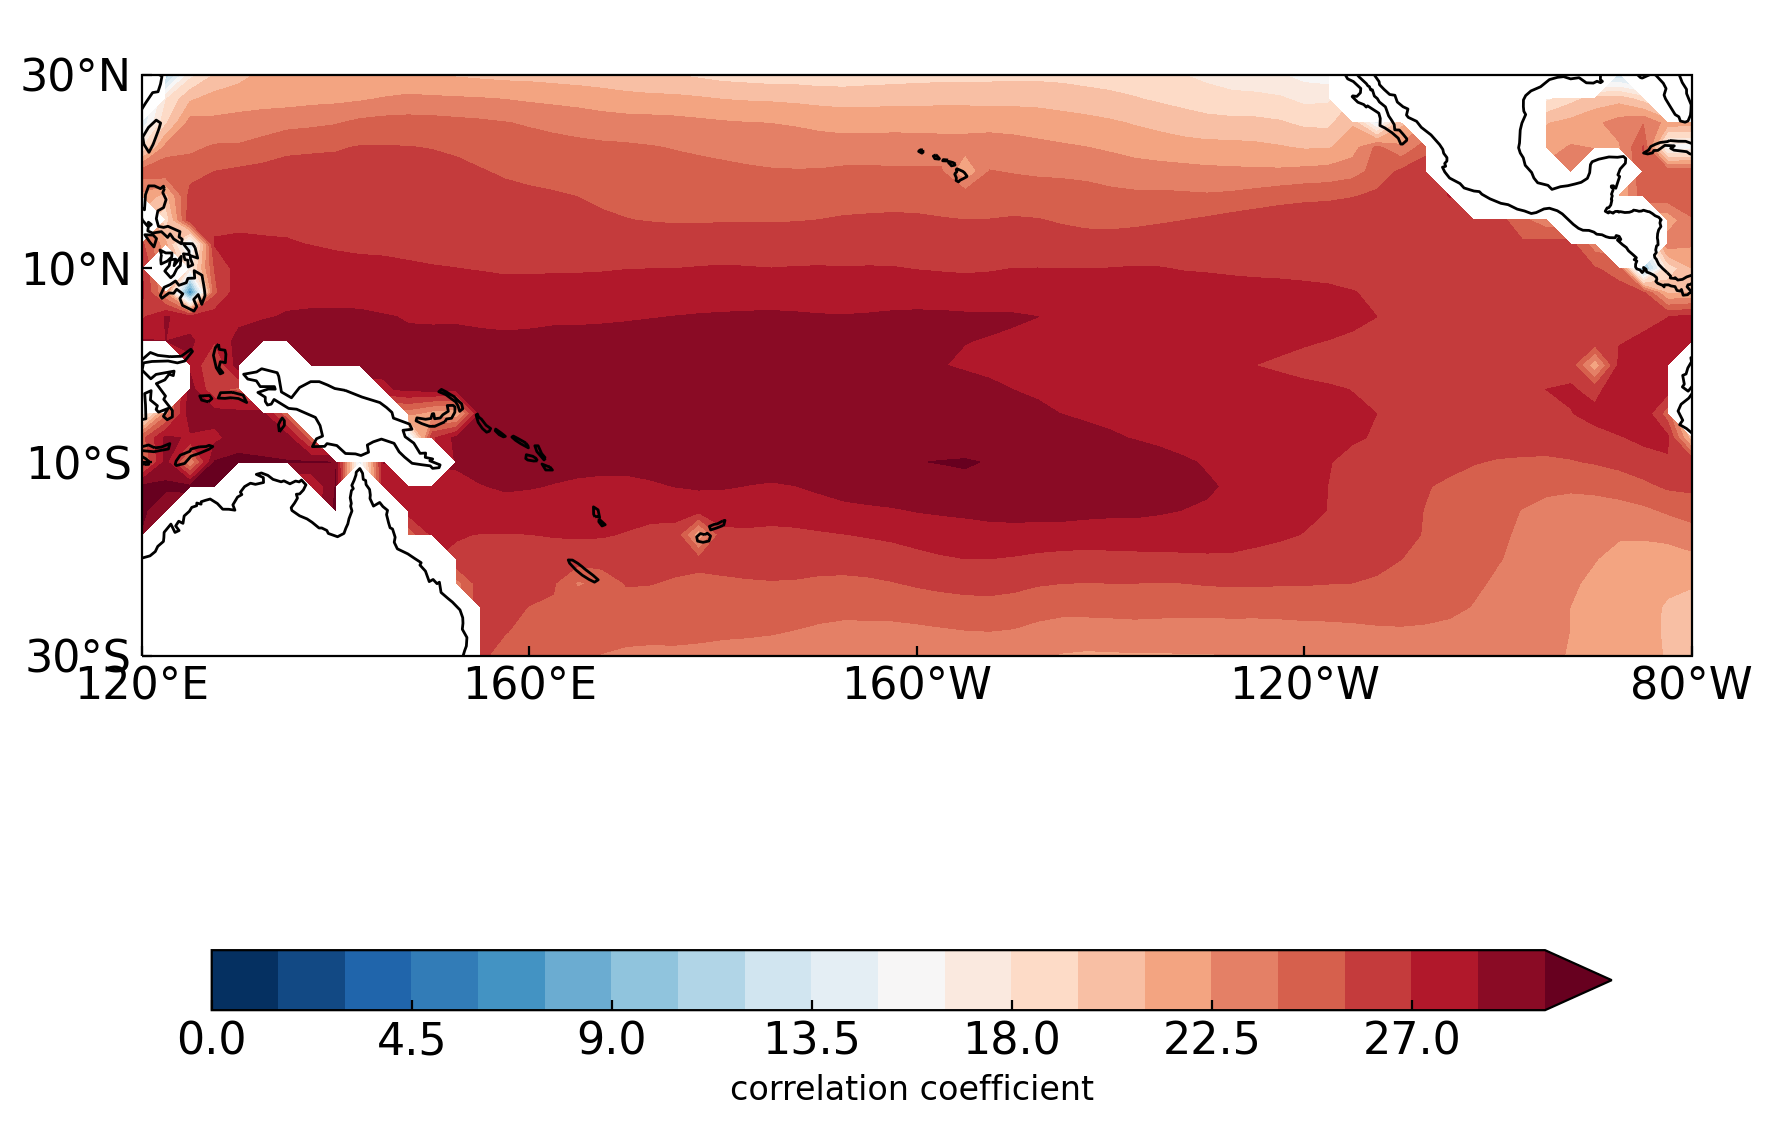

In [11]:
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams.update({'font.size': 16})
# sns.set_theme(style="white")

clevs = np.linspace(-0, 30, 21)
projection = ccrs.PlateCarree(central_longitude=180)

fig = plt.figure(figsize=(10, 10), dpi = 100)
ax = fig.add_subplot(projection = projection)
ax.set_title(f' ', loc = 'left', fontsize = 18, fontweight = 'bold')
ax.set_xticks(np.linspace(-180, 180, 10), crs=projection)
ax.set_yticks(np.linspace(-90, 90, 10), crs=projection)
lon_formatter = LongitudeFormatter(zero_direction_label=True)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)

cs = sst.sel(lead_time = 11, member = 10).isel(time = 0)\
            .plot.contourf(ax = ax,
                           cmap = plt.cm.RdBu_r,
                           add_colorbar = False,
                           transform=ccrs.PlateCarree(),
                           levels = clevs,
                           add_labels = False  # 用来消除没用的标题和轴名称
                           )

#                      [left, bottom, width, height]
cbar_ax = fig.add_axes([0.16, 0.18,   0.70,  0.03])
cb = plt.colorbar(cs, orientation='horizontal', cax = cbar_ax)
cb.set_label('correlation coefficient', fontsize=12)
ax.coastlines()